In [1]:
import scipy
import scipy.misc
import numpy as np
import random
import tensorflow as tf
import gym
from tqdm import tqdm
from tqdm import tqdm_notebook
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lasagne
import theano.tensor as T
import theano

In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
class LunarLanding_wrapper():
    def __init__(self):
        self.state_size = (1, 8)
        self.game_title = "LunarLander-v2"
        self.actions = ["DO_NOTHING", "FIRE_LEFT", "FIRE_MAIN", "FIRE_RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [9]:
class CartPole_wrapper():
    def __init__(self):
        self.state_size = (1, 4)
        self.game_title = "CartPole-v0"
        self.actions = ["LEFT", "RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [10]:
class AVQ_nn():
    def __init__(self, channels_number = 4, image_shape = (1, 8), n_actions = 4, grad_clipping = 10, lr = 0.0001):
        self.input_var = T.tensor4('input')
        
        self.n_actions = n_actions
        self.build_network(channels_number, image_shape)
        self.build_AVQ(grad_clipping, lr)
        self.compile_network()
        
    def build_network(self, channels_number, image_shape):
        self.l1 = lasagne.layers.InputLayer(shape=(None, channels_number, image_shape[0], image_shape[1]), 
                                            input_var = self.input_var)
        self.l2 = lasagne.layers.DenseLayer(self.l1, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.l3 = lasagne.layers.DenseLayer(self.l2, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.outlayer = lasagne.layers.DenseLayer(self.l3, 50, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    def build_AVQ(self, grad_clipping, lr):
        self.l_advantage = lasagne.layers.DenseLayer(self.outlayer, self.n_actions)
        self.l_value = lasagne.layers.DenseLayer(self.outlayer, 1)
        
        self.advantage, self.value = lasagne.layers.get_output([self.l_advantage, self.l_value])

        self.average_advantage = T.mean(self.advantage, keepdims = True, axis = 1)
        
#        self.Qout = self.advantage + self.value - self.average_advantage
        self.Qout = self.advantage + self.value * 0
        self.predict = T.argmax(self.Qout, axis = 1)
        
        self.targetQ = T.fvector('targetQ')
        self.actions = T.ivector('actions')
        self.actions_onehot = T.extra_ops.to_one_hot(self.actions, self.n_actions, dtype=np.float32)
        
        self.Q = T.sum(self.Qout * self.actions_onehot, axis = 1)
        
        self.td_error = T.sqr(self.targetQ - self.Q)
        self.loss = T.mean(self.td_error)
        
        params = self.get_all_params()
        self.all_grads = T.grad(self.loss, params)
        self.scaled_grads = lasagne.updates.total_norm_constraint(self.all_grads, grad_clipping)
        self.updates = lasagne.updates.adam(self.scaled_grads, params, learning_rate=lr)
        
    def compile_network(self):
        self.Qout_fn = theano.function([self.input_var], self.Qout)
        self.actionpred_fn = theano.function([self.input_var], self.predict)
        self.train_fn = theano.function([self.input_var, self.targetQ, self.actions], self.loss, updates = self.updates)
    
    def get_all_params(self):
        return lasagne.layers.get_all_params([self.l_advantage, self.l_value], trainable = True)
    
    def get_all_params_values(self):
        return lasagne.layers.get_all_param_values([self.l_advantage, self.l_value], trainable = True)
    
    def set_all_params_values(self, values):
        return lasagne.layers.set_all_param_values([self.l_advantage, self.l_value], values, trainable = True)

In [11]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [12]:
class window_aggregator():
    def __init__(self, window_length, state_shape):
        self.state_shape = state_shape
        self.window_length = window_length
        
        assert len(self.state_shape) == 2
        assert self.window_length >= 1
        
        self.start_aggregator_shape = (window_length, state_shape[0], state_shape[1])
                                             
        self.aggregator = np.zeros(self.start_aggregator_shape)
        
    def reset(self):
        self.aggregator = np.zeros(self.start_aggregator_shape)
                                       
    def add_state(self, state):
        state = np.expand_dims(state, 0)
        self.aggregator = np.append(self.aggregator, state, axis = 0)
    
    def get_window(self):
        return self.aggregator[-self.window_length:,:,:]                                                                           

In [13]:
class egreedy_agent():
    def __init__(self, n_actions, actionpred_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            a = np.random.randint(0, self.n_actions)
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [14]:
class boltzman_agent:
    def __init__(self, n_actions, Qout_fn, startT = 1000, endT = 0.1, anneling_steps = 50000):
        self.startT = startT
        self.endT = endT
        self.anneling_steps = anneling_steps
        self.logstep = (np.log(startT) - np.log(endT)) / anneling_steps
        self.n_actions = n_actions
        self.Qout_fn = Qout_fn
    
    def choose_action(self, state, current_step):
        scores = self.Qout_fn(np.expand_dims(state, axis = 0))[0]
        if current_step > self.anneling_steps:
            exponents = np.exp((scores - np.max(scores)) / self.endT)
        else:
            current_temp = self.startT / np.exp(self.logstep * current_step)
            exponents = np.exp((scores - np.max(scores)) / current_temp)
        probs = exponents / np.sum(exponents)
        return np.random.choice(self.n_actions, p = probs)

In [46]:
class DDQL():
    def __init__(self, lparams, env, agent = {"agent":"egreedy", "params":{}}):
        self.grad_clip = lparams["grad_clipping"]
        self.lr = lparams["learning_rate"]
        self.window_size = lparams["window_size"]
        self.batch_size = lparams["batch_size"]
        self.gamma = lparams["gamma"]
        self.MQN_updatefreq = lparams["MQN_updatefreq"]
        self.TQN_updatefreq = lparams["TQN_updatefreq"]
        self.TQN_updaterate = lparams["TQN_updaterate"]
        self.print_freq = lparams["print_freq"]
        self.pretrain_steps = lparams["pretrain_steps"]
        self.buffer_size = lparams["buffer_size"]
        self.pretrain_over = False
        
        self.env = env
        self.mainQN = AVQ_nn(self.window_size, self.env.state_size, self.env.n_actions, self.grad_clip, self.lr)
        self.targetQN = AVQ_nn(self.window_size, self.env.state_size, self.env.n_actions, self.grad_clip, self.lr)

        self.jList = []
        self.rList = []
        self.total_steps = 0
        
        self.window = window_aggregator(self.window_size, self.env.state_size)
        self.experience_storage = experience_buffer(self.buffer_size)
        self.agent = self.getAgent(agent["agent"], agent["params"])
            
    def getAgent(self, agent, agentparams):
        if agent == "egreedy":
            return egreedy_agent(self.env.n_actions, self.mainQN.actionpred_fn, **agentparams)
        elif agent == "boltzman":
            return boltzman_agent(self.env.n_actions, self.mainQN.Qout_fn, **agentparams)
        else:
            raise ValueError("Unknown agent")
            
    def updateTarget(self):
        self.targetQN.set_all_params_values(self.mainQN.get_all_params_values())
    
    def discount_rewards(self, r):
        return r
        
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(xrange(0, r.size)):
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r

    def train(self, num_episodes, frame_limit, render = True):
        self.updateTarget()
        self.window.reset()
            
        for episode_num in tqdm_notebook(range(num_episodes), desc = "RL train"):
            episode_storage = experience_buffer()
            state = self.env.make_reset()
            self.window.add_state(state)
            window_state = self.window.get_window()
                
            for iteration in xrange(0, frame_limit):
                action = self.agent.choose_action(window_state, self.total_steps)
                new_state, reward, gameover, _ = self.env.make_step(action, render)
                self.window.add_state(new_state)
                new_window_state = self.window.get_window()
                episode_storage.add(np.reshape(np.array([window_state, action, reward, new_window_state, gameover]),[1,5]))
                    
                if self.pretrain_over:
                    self.total_steps += 1
                
                    if self.total_steps % (self.TQN_updatefreq) == 0:
                        self.updateTarget()
                
                    if self.total_steps % (self.MQN_updatefreq) == 0:
                        train_batch = self.experience_storage.sample(self.batch_size)
                        new_state_batch = np.stack(train_batch[:,3])
                        old_state_batch = np.stack(train_batch[:,0])
                        Q1 = self.mainQN.actionpred_fn(new_state_batch)   
                        Q2 = self.targetQN.Qout_fn(new_state_batch)
#                        Q2 = self.mainQN.Qout_fn(new_state_batch)
                        end_multiplier = -(train_batch[:,4] - 1)
                        doubleQ = Q2[range(self.batch_size),Q1]
                        targetQ = (train_batch[:,2] + (self.gamma * doubleQ * end_multiplier)).astype(np.float32)
                        action_vector = (train_batch[:,1]).astype(np.int32)
                        _ = self.mainQN.train_fn(old_state_batch, targetQ, action_vector)
                         
                else:
                    self.pretrain_steps -= 1;
                    if self.pretrain_steps <= 0:
                        self.pretrain_over = True
                        
                state = new_state
                window_state = new_window_state
            
                if gameover:
                    self.window.reset()
                    break
    
            episode_rewards = np.array(episode_storage.buffer)[:,2]
            total_reward = np.sum(episode_rewards)
            discount_rewards = self.discount_rewards(episode_rewards)
            buffer_array = np.array(episode_storage.buffer)
            buffer_array[:,2] = discount_rewards
            self.experience_storage.add(zip(buffer_array))
            self.jList.append(iteration)
            self.rList.append(total_reward)
            if len(self.rList) % self.print_freq == 0:
                tqdm.write(" ".join(["========= Episode", str(episode_num), "================================================"]))
                tqdm.write(" ".join(["Total steps:", str(self.total_steps)]))
                tqdm.write(" ".join(["Episode rewards, last 10:", str(self.rList[-10:])]))
                tqdm.write(" ".join(["Mean over last", str(self.print_freq), "episodes:", str(np.mean(self.rList[-self.print_freq:]))]))
                tqdm.write(" ".join(["Episode lengths, last 10:", str(self.jList[-10:])]))
                tqdm.write("===================================================================" + "=" * len(str(episode_num)))

In [73]:
def plot_rewards(ddqlmodel, meanwindow = 250):
    rlist = [ddqlmodel.rList[0]] * meanwindow + ddqlmodel.rList
    x = [np.mean(rlist[k:k+meanwindow]) for k in range(len(rlist) - meanwindow)]
    plt.plot(np.arange(len(x)), x)

In [47]:
#envhandle = LunarLanding_wrapper()
envhandle = CartPole_wrapper()

[2017-04-30 02:05:37,496] Making new env: CartPole-v0


In [ ]:
lparams = {"grad_clipping" : 50,
           "learning_rate" : 0.005,
           "window_size" : 1,
           "batch_size" : 8,
           "buffer_size" : 128,
           "gamma" : 0.98,
           "MQN_updatefreq" : 1,
           "TQN_updatefreq" : 16,
           "TQN_updaterate" : 0.01,
           "print_freq" : 500,
           "pretrain_steps" : 5000,
           "render" : False}

In [49]:
egreedyagentinfo = {"agent" : "egreedy",
                    "params" : {"startE": 0.5,
                                "endE" : 0.1,
                                "anneling_steps":1000}}

In [50]:
boltzmanagentinfo = {"agent" : "boltzman",
                     "params" : {"startT": 10,
                                 "endT" : 1,
                                 "anneling_steps":10000}}

In [51]:
ddql = DDQL(lparams, envhandle, egreedyagentinfo)

In [52]:
ddql.train(num_episodes = 5000, frame_limit = 500, render = False)

========= Episode 499 ================================================
Total steps: 1083
Episode rewards, last 10: [9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 12.0, 10.0]
Mean over last 500 episodes: 12.166
Episode lengths, last 10: [8, 9, 9, 9, 9, 9, 9, 9, 11, 9]
========= Episode 999 ================================================
Total steps: 6048
Episode rewards, last 10: [10.0, 12.0, 11.0, 10.0, 12.0, 11.0, 9.0, 10.0, 8.0, 9.0]
Mean over last 500 episodes: 9.93
Episode lengths, last 10: [9, 11, 10, 9, 11, 10, 8, 9, 7, 8]
========= Episode 1499 ================================================
Total steps: 10989
Episode rewards, last 10: [10.0, 12.0, 10.0, 9.0, 11.0, 10.0, 11.0, 9.0, 10.0, 11.0]
Mean over last 500 episodes: 9.882
Episode lengths, last 10: [9, 11, 9, 8, 10, 9, 10, 8, 9, 10]
========= Episode 1999 ================================================
Total steps: 64722
Episode rewards, last 10: [103.0, 93.0, 127.0, 70.0, 124.0, 40.0, 15.0, 359.0, 67.0, 132.0]
Mean ove

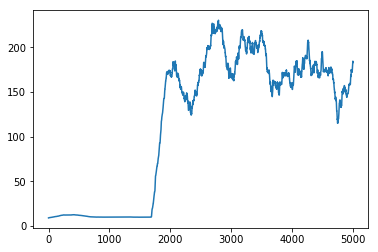

In [75]:
plot_rewards(ddql)

Е-жадная стратегия.

In [61]:
ddql2 = DDQL(lparams, envhandle, egreedyagentinfo)

In [62]:
ddql2.train(num_episodes = 5000, frame_limit = 500, render = False)

========= Episode 499 ================================================
Total steps: 10113
Episode rewards, last 10: [141.0, 240.0, 145.0, 266.0, 94.0, 122.0, 130.0, 136.0, 169.0, 279.0]
Mean over last 500 episodes: 30.226
Episode lengths, last 10: [140, 239, 144, 265, 93, 121, 129, 135, 168, 278]
========= Episode 999 ================================================
Total steps: 93181
Episode rewards, last 10: [39.0, 162.0, 19.0, 26.0, 13.0, 245.0, 30.0, 128.0, 17.0, 32.0]
Mean over last 500 episodes: 166.136
Episode lengths, last 10: [38, 161, 18, 25, 12, 244, 29, 127, 16, 31]
========= Episode 1499 ================================================
Total steps: 191764
Episode rewards, last 10: [484.0, 500.0, 500.0, 201.0, 18.0, 141.0, 196.0, 13.0, 307.0, 119.0]
Mean over last 500 episodes: 197.166
Episode lengths, last 10: [483, 499, 499, 200, 17, 140, 195, 12, 306, 118]
========= Episode 1999 ================================================
Total steps: 291436
Episode rewards, last 10

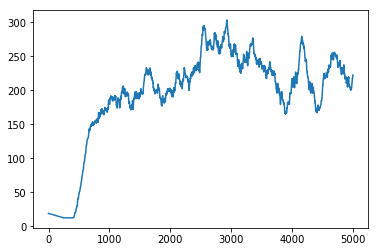

In [76]:
plot_rewards(ddql2)

Е-жадная стратегия.

In [84]:
ddql4 = DDQL(lparams, envhandle, boltzmanagentinfo)

In [85]:
ddql4.train(num_episodes = 2500, frame_limit = 500, render = False)

========= Episode 499 ================================================
Total steps: 36629
Episode rewards, last 10: [136.0, 500.0, 302.0, 124.0, 500.0, 248.0, 148.0, 316.0, 37.0, 113.0]
Mean over last 500 episodes: 83.258
Episode lengths, last 10: [135, 499, 301, 123, 499, 247, 147, 315, 36, 112]
========= Episode 999 ================================================
Total steps: 132740
Episode rewards, last 10: [26.0, 62.0, 102.0, 147.0, 184.0, 204.0, 500.0, 207.0, 500.0, 500.0]
Mean over last 500 episodes: 192.222
Episode lengths, last 10: [25, 61, 101, 146, 183, 203, 499, 206, 499, 499]
========= Episode 1499 ================================================
Total steps: 234274
Episode rewards, last 10: [18.0, 148.0, 113.0, 29.0, 111.0, 18.0, 21.0, 202.0, 148.0, 393.0]
Mean over last 500 episodes: 203.068
Episode lengths, last 10: [17, 147, 112, 28, 110, 17, 20, 201, 147, 392]
========= Episode 1999 ================================================
Total steps: 324370
Episode rewards, 

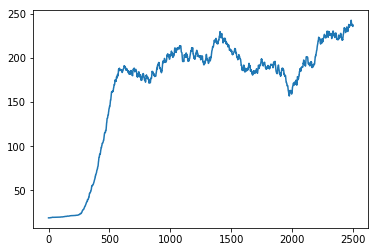

In [86]:
plot_rewards(ddql4)

Как видно из графиков(первые два - е-жадная стратегия, третий - стратегия с сглаживанием больцмана), процесс обучения нестабилен, т.е. алгоритм проводит неопределенное количество времени с маленькой наградой(зависит от начальной инициализации весов и последовательностью сгенерированных эпизодов окружения), только после чего он начинает обучаться.

Для построения наиболее иллюстративных графиков эффектов реализуемых алгоритмов необходимо запускать алгоритм несколько раз (желательно более десяти), и строить графики, показывающие средние значения и средние отклонения наград.